In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10792393765090095480
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13822697197087243349
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4985044352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17544739553507074465
physical_device_desc: "device: 0, name: GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1770810990171559402
physical_device_desc: "device: XLA_GPU device"
]


# 1) Library Load

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Reshape, Input, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.engine.topology import Layer
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras import backend as K

from attention import Attention

Using TensorFlow backend.


In [3]:
version = 'v1'

# 2) Data Load

In [4]:
train_df = pd.read_csv("D:/dacon/Vegetable_Price/data/public_data/train.csv")
train_df

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,...,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,...,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
4,2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,...,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2020-09-24,목요일,1856965.0,1839.0,2055640.0,990.0,2281429.2,990.0,2818.4,19101.0,...,50730.0,4509.0,282212.3,3001.0,313139.7,3426.0,504242.6,3620.0,283196.9,10940.0
1729,2020-09-25,금요일,1880095.5,1789.0,1879261.0,1011.0,2074513.0,955.0,1887.1,23095.0,...,54322.0,4178.0,312214.8,2999.0,362741.0,3357.0,479683.1,3618.0,303779.6,10844.0
1730,2020-09-26,토요일,1661090.9,1760.0,1709385.7,1075.0,2089081.2,961.0,959.0,22510.0,...,61213.0,3770.0,327395.8,3065.0,390361.2,3092.0,521493.8,3691.0,313295.7,10636.0
1731,2020-09-27,일요일,25396.0,3066.0,38222.0,1139.0,18240.0,1056.0,60.0,22333.0,...,144.0,4076.0,285.0,3707.0,2464.0,3252.0,21717.0,3567.0,9734.0,10699.0


# 3) Data Preprocessing

In [5]:
week_day_map = {}
for i, d in enumerate(train_df['요일'].unique()):
    week_day_map[d] = i
train_df['요일'] = train_df['요일'].map(week_day_map)

In [6]:
norm = train_df.iloc[:, 1:].max(0)
train_df.iloc[:, 1:] = train_df.iloc[:, 1:] / norm

In [7]:
train_df

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,2016-01-02,0.166667,0.015520,0.0658,0.020797,0.264706,0.024437,0.6405,0.000007,0.064389,...,0.060900,0.511068,0.000197,0.398376,0.023032,0.356152,0.000590,0.08056,0.000000,0.000000
2,2016-01-03,0.333333,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,2016-01-04,0.500000,0.273068,0.0956,0.440354,0.280882,0.460735,0.6175,0.001690,0.026130,...,0.457792,0.422302,0.227365,0.386475,0.745976,0.297728,0.001814,0.15540,0.000000,0.000000
4,2016-01-05,0.666667,0.224029,0.0884,0.368802,0.310294,0.416530,0.6065,0.002690,0.025416,...,0.387559,0.383287,0.067041,0.428410,0.278846,0.321334,0.005911,0.11412,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2020-09-24,1.000000,0.356409,0.3678,0.532584,0.727941,0.454038,0.4950,0.006813,0.111809,...,0.602816,0.249530,0.128151,0.566868,0.376438,0.505459,0.338341,0.14480,0.740842,0.273500
1729,2020-09-25,0.000000,0.360848,0.3578,0.486887,0.743382,0.412859,0.4775,0.004562,0.135188,...,0.645499,0.231212,0.141775,0.566490,0.436066,0.495279,0.321862,0.14472,0.794687,0.271100
1730,2020-09-26,0.166667,0.318814,0.3520,0.442875,0.790441,0.415758,0.4805,0.002318,0.131764,...,0.727384,0.208633,0.148668,0.578957,0.469269,0.456182,0.349917,0.14764,0.819581,0.265900
1731,2020-09-27,0.333333,0.004874,0.6132,0.009903,0.837500,0.003630,0.5280,0.000145,0.130728,...,0.001711,0.225567,0.000129,0.700227,0.002962,0.479788,0.014572,0.14268,0.025464,0.267475


In [8]:
train_df.shape

(1733, 44)

# 4) Data Reshape

In [9]:
target_n = 21 # 맞춰야하는 품목/품종의 수
window_size = 28 # 인코더 시퀀스 길이
future_size = 28 # 디코더 시퀀스 길이

In [10]:
x_data = []
y_data = []

for i in tqdm(range(train_df.shape[0]-window_size-future_size)):
    x = train_df.iloc[i:i+window_size, 1:]
    y = train_df.iloc[i+window_size:i+window_size+future_size, 3::2]
    x_data.append(x)
    y_data.append(y)
x_data = np.array(x_data)
y_data = np.array(y_data)

100%|████████████████████████████████████████████████████████████████████████████| 1677/1677 [00:00<00:00, 2924.00it/s]


In [11]:
x_data.shape, y_data.shape

((1677, 28, 43), (1677, 28, 21))

In [12]:
new_x_data = tf.reshape(x_data, [-1, window_size, 43])
new_y_data = tf.reshape(y_data, [-1, window_size, target_n])

In [13]:
new_x_data.shape, new_y_data.shape

(TensorShape([1677, 28, 43]), TensorShape([1677, 28, 21]))

# 5) Data Split

In [14]:
train_test_split = 164
x_train = new_x_data[:-train_test_split-future_size]
y_train = new_y_data[:-train_test_split-future_size]
x_val = new_x_data[-train_test_split:]
y_val = new_y_data[-train_test_split:]

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(TensorShape([1485, 28, 43]),
 TensorShape([1485, 28, 21]),
 TensorShape([164, 28, 43]),
 TensorShape([164, 28, 21]))

# 6) Training

In [16]:
time = x_train.shape[1]
OUT_STEPS = y_train.shape[1]


with tf.device('/gpu:0'):
    input_1 = Input(shape=(time, x_train.shape[-1]), dtype='float32')
    conv = Conv1D(filters=128, kernel_size=7)(input_1)
    #drop = Dropout(0.5)(conv)
    pool = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(filters=128, kernel_size=4)(pool)
    #drop = Dropout(0.5)(conv)
    pool = MaxPooling1D(pool_size=2)(conv)
    conv = Conv1D(filters=64, kernel_size=2)(pool)
    pool = MaxPooling1D(pool_size=2)(conv)
    flat = Flatten()(pool)
    output_1 = Dense(OUT_STEPS * y_train.shape[-1])(flat)
    output_reshape = Reshape([OUT_STEPS, y_train.shape[-1]])(output_1)
    
    model = Model(inputs = [input_1], outputs = [output_reshape])    
    model.compile(optimizer='rmsprop', loss='mae')
    
    
    model.summary()
    

    es = EarlyStopping(monitor='val_loss', patience=30)
    model_path = 'D:/dacon/Vegetable_Price/CNN/save_models/CNN_{}'.format(version) + '_{epoch:02d}_{val_loss:.5f}.h5'
    mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, mode='auto')

    
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500, batch_size=128, callbacks=[es, mc])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 43)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 128)           38656     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 128)            65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 64)             16448     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 64)             0     

12/12 [==============================] - 0s 8ms/step - loss: 0.0790 - val_loss: 0.0912
Epoch 27/500
11/12 [==========================>...] - ETA: 0s - loss: 0.0776
Epoch 00027: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_27_0.08347.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0774 - val_loss: 0.0835
Epoch 28/500
12/12 [==============================] - ETA: 0s - loss: 0.0769
Epoch 00028: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_28_0.08456.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0769 - val_loss: 0.0846
Epoch 29/500
12/12 [==============================] - ETA: 0s - loss: 0.0775
Epoch 00029: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_29_0.08705.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0775 - val_loss: 0.0871
Epoch 30/500
12/12 [==============================] - ETA: 0s - loss: 0.0754
Epoch 00030: saving model to D:/dacon/Vegetable_Price/CNN/save_models/C

Epoch 59/500
12/12 [==============================] - ETA: 0s - loss: 0.0659
Epoch 00059: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_59_0.08086.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0659 - val_loss: 0.0809
Epoch 60/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0619
Epoch 00060: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_60_0.07803.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0665 - val_loss: 0.0780
Epoch 61/500
12/12 [==============================] - ETA: 0s - loss: 0.0669
Epoch 00061: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_61_0.08153.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0669 - val_loss: 0.0815
Epoch 62/500
11/12 [==========================>...] - ETA: 0s - loss: 0.0648
Epoch 00062: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_62_0.07836.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0648

 1/12 [=>............................] - ETA: 0s - loss: 0.0567
Epoch 00091: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_91_0.08691.h5
12/12 [==============================] - 0s 7ms/step - loss: 0.0599 - val_loss: 0.0869
Epoch 92/500
12/12 [==============================] - ETA: 0s - loss: 0.0604
Epoch 00092: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_92_0.08020.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0604 - val_loss: 0.0802
Epoch 93/500
12/12 [==============================] - ETA: 0s - loss: 0.0604
Epoch 00093: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_93_0.07929.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0604 - val_loss: 0.0793
Epoch 94/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0581
Epoch 00094: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_94_0.08769.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0601 - val_loss: 

Epoch 123/500
12/12 [==============================] - ETA: 0s - loss: 0.0563
Epoch 00123: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_123_0.08349.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0563 - val_loss: 0.0835
Epoch 124/500
12/12 [==============================] - ETA: 0s - loss: 0.0575
Epoch 00124: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_124_0.08754.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0575 - val_loss: 0.0875
Epoch 125/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0562
Epoch 00125: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_125_0.08722.h5
12/12 [==============================] - 0s 8ms/step - loss: 0.0544 - val_loss: 0.0872
Epoch 126/500
 1/12 [=>............................] - ETA: 0s - loss: 0.0568
Epoch 00126: saving model to D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_126_0.08541.h5
12/12 [==============================] - 0s 8ms/step - loss

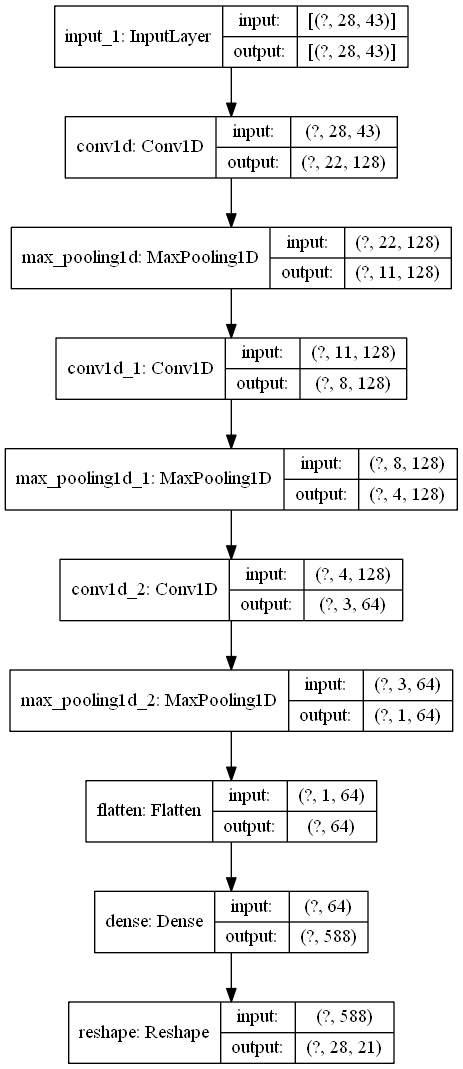

In [17]:
tf.keras.utils.plot_model(model, to_file='./CNN_{}.png'.format(version), show_shapes=True, show_layer_names=True)

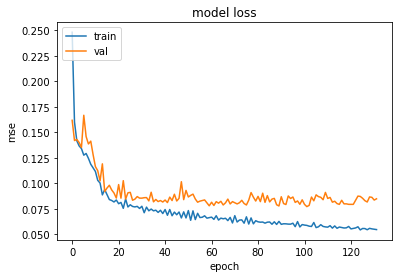

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7) Test for Inference Data

In [19]:
trained_model = load_model('D:/dacon/Vegetable_Price/CNN/save_models/CNN_v1_122_0.07944.h5')

In [20]:
submission = pd.read_csv('D:/dacon/Vegetable_Price/data/sample_submission.csv')

In [21]:
public_date_list = submission[submission['예측대상일자'].str.contains('2020')]['예측대상일자'].str.split('+').str[0].unique()

In [22]:
inference_submission = pd.DataFrame(columns=submission.columns)

In [23]:
inference_submission['예측대상일자'] = public_date_list.tolist()
inference_submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
outputs = []
norm_ = norm.to_numpy()[2::2]

for idx, date in tqdm(zip(range(len(public_date_list) - window_size +1), public_date_list)):
    test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{date}.csv')
    data = pd.read_csv('D:/dacon/Vegetable_Price/data/public_data/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]
    
    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm
    
    new_data = tf.reshape(data, [-1, window_size, 43])
    output = trained_model.predict(new_data)*norm_

    inference_submission.loc[idx:idx+window_size-1, '배추_가격(원/kg)':] = output[0]

11it [00:00, 19.10it/s]


In [25]:
inference_submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1091.715693,566.789422,575.429559,15161.293601,828.70824,1306.789058,1071.320604,647.984303,6007.365995,...,822.578743,6373.281282,1740.407228,2015.773447,2604.961009,4503.980255,1776.340696,2269.59925,2875.980921,2697.201967
1,2020-09-30,1310.980767,788.489184,744.339883,18175.272484,1577.765895,1698.36044,1597.647981,703.904653,7598.690259,...,1127.02243,5806.494742,2533.375502,2334.029146,2450.229722,4522.246047,2156.37555,2316.03888,3043.771908,4924.59774
2,2020-10-01,1256.431937,768.982348,823.812723,19042.841813,2105.514921,1860.927688,1675.017774,859.781294,9595.554564,...,1169.928722,6931.813522,2899.241924,2984.398658,2879.663922,5626.686664,2382.361626,2668.38308,3421.40682,5939.759612
3,2020-10-02,1581.953615,1090.357714,928.687513,17427.931883,2213.586225,2174.190483,2125.586109,981.014723,9151.339859,...,1485.700384,6174.82004,3003.095627,3456.503285,3013.961269,7012.203874,2322.325498,2670.655986,3681.853414,9016.219378
4,2020-10-03,1562.413871,968.579173,883.527458,19582.449347,1940.412528,2052.68145,2125.267256,973.309806,10216.470266,...,1217.104197,7413.765914,2980.914354,3343.518433,2758.38954,6200.434358,2636.033322,2850.8288,3285.513073,2846.947908
5,2020-10-04,1139.821708,599.658084,334.401041,10539.602628,-484.145215,1329.86855,1162.158455,482.597498,5608.530747,...,787.299983,4290.557166,1559.185505,1799.796274,1757.458935,4654.353958,1162.408055,1834.026547,3120.342642,2666.105926
6,2020-10-05,1436.408162,792.039227,421.890408,9750.590932,4.378065,1418.488774,1750.511734,670.998452,6667.388433,...,932.431798,5376.83878,2038.389921,2208.603408,2062.2562,4873.099709,1594.624442,2432.128563,2260.076255,-183.181912
7,2020-10-06,996.468812,642.628326,511.862576,17436.063978,-178.477957,1181.547951,1177.120224,689.863559,6165.470843,...,810.428895,6083.998616,1669.436932,2162.600532,2690.062166,4414.765559,1934.801925,2446.161513,3685.050458,-778.483599
8,2020-10-07,1164.916605,759.349308,581.122637,16303.074499,-183.989635,1636.244245,1554.353438,728.091802,6375.14504,...,920.988098,5982.852799,1969.031334,2373.054925,2565.680351,3817.314556,1896.96295,2260.006465,3509.534895,1189.226061
9,2020-10-08,962.923765,709.184704,607.437611,14949.016541,-121.695881,1524.848177,1518.532476,549.525119,6513.307144,...,747.392066,5548.989709,1841.196775,2153.471454,2815.31555,3091.569228,1843.275943,1752.182554,4391.282052,1078.484952


In [26]:
inference_submission = inference_submission.rename(columns={'예측대상일자':'date'})
inference_submission

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1091.715693,566.789422,575.429559,15161.293601,828.70824,1306.789058,1071.320604,647.984303,6007.365995,...,822.578743,6373.281282,1740.407228,2015.773447,2604.961009,4503.980255,1776.340696,2269.59925,2875.980921,2697.201967
1,2020-09-30,1310.980767,788.489184,744.339883,18175.272484,1577.765895,1698.36044,1597.647981,703.904653,7598.690259,...,1127.02243,5806.494742,2533.375502,2334.029146,2450.229722,4522.246047,2156.37555,2316.03888,3043.771908,4924.59774
2,2020-10-01,1256.431937,768.982348,823.812723,19042.841813,2105.514921,1860.927688,1675.017774,859.781294,9595.554564,...,1169.928722,6931.813522,2899.241924,2984.398658,2879.663922,5626.686664,2382.361626,2668.38308,3421.40682,5939.759612
3,2020-10-02,1581.953615,1090.357714,928.687513,17427.931883,2213.586225,2174.190483,2125.586109,981.014723,9151.339859,...,1485.700384,6174.82004,3003.095627,3456.503285,3013.961269,7012.203874,2322.325498,2670.655986,3681.853414,9016.219378
4,2020-10-03,1562.413871,968.579173,883.527458,19582.449347,1940.412528,2052.68145,2125.267256,973.309806,10216.470266,...,1217.104197,7413.765914,2980.914354,3343.518433,2758.38954,6200.434358,2636.033322,2850.8288,3285.513073,2846.947908
5,2020-10-04,1139.821708,599.658084,334.401041,10539.602628,-484.145215,1329.86855,1162.158455,482.597498,5608.530747,...,787.299983,4290.557166,1559.185505,1799.796274,1757.458935,4654.353958,1162.408055,1834.026547,3120.342642,2666.105926
6,2020-10-05,1436.408162,792.039227,421.890408,9750.590932,4.378065,1418.488774,1750.511734,670.998452,6667.388433,...,932.431798,5376.83878,2038.389921,2208.603408,2062.2562,4873.099709,1594.624442,2432.128563,2260.076255,-183.181912
7,2020-10-06,996.468812,642.628326,511.862576,17436.063978,-178.477957,1181.547951,1177.120224,689.863559,6165.470843,...,810.428895,6083.998616,1669.436932,2162.600532,2690.062166,4414.765559,1934.801925,2446.161513,3685.050458,-778.483599
8,2020-10-07,1164.916605,759.349308,581.122637,16303.074499,-183.989635,1636.244245,1554.353438,728.091802,6375.14504,...,920.988098,5982.852799,1969.031334,2373.054925,2565.680351,3817.314556,1896.96295,2260.006465,3509.534895,1189.226061
9,2020-10-08,962.923765,709.184704,607.437611,14949.016541,-121.695881,1524.848177,1518.532476,549.525119,6513.307144,...,747.392066,5548.989709,1841.196775,2153.471454,2815.31555,3091.569228,1843.275943,1752.182554,4391.282052,1078.484952


In [27]:
inference_submission_1 = inference_submission.iloc[:-1]
inference_submission_1

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1091.715693,566.789422,575.429559,15161.293601,828.70824,1306.789058,1071.320604,647.984303,6007.365995,...,822.578743,6373.281282,1740.407228,2015.773447,2604.961009,4503.980255,1776.340696,2269.59925,2875.980921,2697.201967
1,2020-09-30,1310.980767,788.489184,744.339883,18175.272484,1577.765895,1698.36044,1597.647981,703.904653,7598.690259,...,1127.02243,5806.494742,2533.375502,2334.029146,2450.229722,4522.246047,2156.37555,2316.03888,3043.771908,4924.59774
2,2020-10-01,1256.431937,768.982348,823.812723,19042.841813,2105.514921,1860.927688,1675.017774,859.781294,9595.554564,...,1169.928722,6931.813522,2899.241924,2984.398658,2879.663922,5626.686664,2382.361626,2668.38308,3421.40682,5939.759612
3,2020-10-02,1581.953615,1090.357714,928.687513,17427.931883,2213.586225,2174.190483,2125.586109,981.014723,9151.339859,...,1485.700384,6174.82004,3003.095627,3456.503285,3013.961269,7012.203874,2322.325498,2670.655986,3681.853414,9016.219378
4,2020-10-03,1562.413871,968.579173,883.527458,19582.449347,1940.412528,2052.68145,2125.267256,973.309806,10216.470266,...,1217.104197,7413.765914,2980.914354,3343.518433,2758.38954,6200.434358,2636.033322,2850.8288,3285.513073,2846.947908
5,2020-10-04,1139.821708,599.658084,334.401041,10539.602628,-484.145215,1329.86855,1162.158455,482.597498,5608.530747,...,787.299983,4290.557166,1559.185505,1799.796274,1757.458935,4654.353958,1162.408055,1834.026547,3120.342642,2666.105926
6,2020-10-05,1436.408162,792.039227,421.890408,9750.590932,4.378065,1418.488774,1750.511734,670.998452,6667.388433,...,932.431798,5376.83878,2038.389921,2208.603408,2062.2562,4873.099709,1594.624442,2432.128563,2260.076255,-183.181912
7,2020-10-06,996.468812,642.628326,511.862576,17436.063978,-178.477957,1181.547951,1177.120224,689.863559,6165.470843,...,810.428895,6083.998616,1669.436932,2162.600532,2690.062166,4414.765559,1934.801925,2446.161513,3685.050458,-778.483599
8,2020-10-07,1164.916605,759.349308,581.122637,16303.074499,-183.989635,1636.244245,1554.353438,728.091802,6375.14504,...,920.988098,5982.852799,1969.031334,2373.054925,2565.680351,3817.314556,1896.96295,2260.006465,3509.534895,1189.226061
9,2020-10-08,962.923765,709.184704,607.437611,14949.016541,-121.695881,1524.848177,1518.532476,549.525119,6513.307144,...,747.392066,5548.989709,1841.196775,2153.471454,2815.31555,3091.569228,1843.275943,1752.182554,4391.282052,1078.484952


In [28]:
inference_submission_2 = inference_submission_1.copy()

for col in inference_submission_2.columns[1:]:
    inference_submission_2[col] = inference_submission_2[col].apply(lambda x : 0 if x <= 0 else x)

inference_submission_2

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1091.715693,566.789422,575.429559,15161.293601,828.708240,1306.789058,1071.320604,647.984303,6007.365995,...,822.578743,6373.281282,1740.407228,2015.773447,2604.961009,4503.980255,1776.340696,2269.599250,2875.980921,2697.201967
1,2020-09-30,1310.980767,788.489184,744.339883,18175.272484,1577.765895,1698.360440,1597.647981,703.904653,7598.690259,...,1127.022430,5806.494742,2533.375502,2334.029146,2450.229722,4522.246047,2156.375550,2316.038880,3043.771908,4924.597740
2,2020-10-01,1256.431937,768.982348,823.812723,19042.841813,2105.514921,1860.927688,1675.017774,859.781294,9595.554564,...,1169.928722,6931.813522,2899.241924,2984.398658,2879.663922,5626.686664,2382.361626,2668.383080,3421.406820,5939.759612
3,2020-10-02,1581.953615,1090.357714,928.687513,17427.931883,2213.586225,2174.190483,2125.586109,981.014723,9151.339859,...,1485.700384,6174.820040,3003.095627,3456.503285,3013.961269,7012.203874,2322.325498,2670.655986,3681.853414,9016.219378
4,2020-10-03,1562.413871,968.579173,883.527458,19582.449347,1940.412528,2052.681450,2125.267256,973.309806,10216.470266,...,1217.104197,7413.765914,2980.914354,3343.518433,2758.389540,6200.434358,2636.033322,2850.828800,3285.513073,2846.947908
5,2020-10-04,1139.821708,599.658084,334.401041,10539.602628,0.000000,1329.868550,1162.158455,482.597498,5608.530747,...,787.299983,4290.557166,1559.185505,1799.796274,1757.458935,4654.353958,1162.408055,1834.026547,3120.342642,2666.105926
6,2020-10-05,1436.408162,792.039227,421.890408,9750.590932,4.378065,1418.488774,1750.511734,670.998452,6667.388433,...,932.431798,5376.838780,2038.389921,2208.603408,2062.256200,4873.099709,1594.624442,2432.128563,2260.076255,0.000000
7,2020-10-06,996.468812,642.628326,511.862576,17436.063978,0.000000,1181.547951,1177.120224,689.863559,6165.470843,...,810.428895,6083.998616,1669.436932,2162.600532,2690.062166,4414.765559,1934.801925,2446.161513,3685.050458,0.000000
8,2020-10-07,1164.916605,759.349308,581.122637,16303.074499,0.000000,1636.244245,1554.353438,728.091802,6375.145040,...,920.988098,5982.852799,1969.031334,2373.054925,2565.680351,3817.314556,1896.962950,2260.006465,3509.534895,1189.226061
9,2020-10-08,962.923765,709.184704,607.437611,14949.016541,0.000000,1524.848177,1518.532476,549.525119,6513.307144,...,747.392066,5548.989709,1841.196775,2153.471454,2815.315550,3091.569228,1843.275943,1752.182554,4391.282052,1078.484952


In [29]:
test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{"2020-11-05"}.csv')
test_df

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2020-09-29,화요일,2064183.3,1787.0,2424383.2,1190.0,1209647.0,966.0,2842.8,25873.0,...,76702.8,3678.0,375798.6,2794.0,450576.5,2350.0,495845.2,3937.0,259765.0,11400.0
1,2020-09-30,수요일,259065.3,1551.0,1044460.0,984.0,136696.4,857.0,35.0,9929.0,...,53183.2,1892.0,387513.8,1858.0,386869.7,1311.0,263761.0,3885.0,121859.6,11649.0
2,2020-10-01,목요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-10-02,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-10-03,토요일,0.0,0.0,3100.0,835.0,0.0,0.0,0.0,0.0,...,724.0,2186.0,0.0,0.0,2552.0,1243.0,0.0,0.0,0.0,0.0
5,2020-10-04,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-10-05,월요일,1965239.2,1483.0,2041917.7,1043.0,1733549.9,1002.0,487.8,23450.0,...,115472.0,1551.0,1207386.1,1027.0,1093237.6,878.0,294465.0,3895.0,192707.1,11803.0
7,2020-10-06,화요일,1784379.1,1359.0,2064575.9,996.0,1611985.7,1095.0,1070.1,16165.0,...,70574.0,1367.0,540580.1,1339.0,454010.8,1112.0,263117.8,3707.0,183881.3,11159.0
8,2020-10-07,수요일,1672867.3,1316.0,2125164.2,901.0,1873624.8,1122.0,1415.6,14654.0,...,57944.0,1355.0,458706.5,1367.0,468148.3,1222.0,263120.0,3407.0,206705.9,10619.0
9,2020-10-08,목요일,1588132.2,1159.0,1780584.9,879.0,1885755.5,1142.0,2361.0,15138.0,...,45074.0,1459.0,429872.0,1261.0,444752.2,1152.0,247170.0,3224.0,202764.1,9873.0


In [30]:
test_df_1 = test_df.loc[:, '배추_가격(원/kg)'::2]
test_df_1 = pd.concat([test_df['date'], test_df_1], axis=1)
test_df_1

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1787.0,1190.0,966.0,25873.0,5404.0,2682.0,2460.0,1584.0,11298.0,...,1743.0,7579.0,3343.0,3102.0,4268.0,3678.0,2794.0,2350.0,3937.0,11400.0
1,2020-09-30,1551.0,984.0,857.0,9929.0,5575.0,2774.0,1513.0,1379.0,6476.0,...,956.0,4770.0,2561.0,2400.0,3550.0,1892.0,1858.0,1311.0,3885.0,11649.0
2,2020-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-10-03,0.0,835.0,0.0,0.0,0.0,3784.0,0.0,0.0,5091.0,...,0.0,0.0,0.0,0.0,3437.0,2186.0,0.0,1243.0,0.0,0.0
5,2020-10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-10-05,1483.0,1043.0,1002.0,23450.0,5683.0,2427.0,1201.0,1653.0,4142.0,...,1665.0,5277.0,2606.0,3156.0,3083.0,1551.0,1027.0,878.0,3895.0,11803.0
7,2020-10-06,1359.0,996.0,1095.0,16165.0,5235.0,2582.0,1204.0,1386.0,3696.0,...,1743.0,4919.0,2554.0,2978.0,3358.0,1367.0,1339.0,1112.0,3707.0,11159.0
8,2020-10-07,1316.0,901.0,1122.0,14654.0,5292.0,2768.0,1138.0,1405.0,3784.0,...,1709.0,5465.0,2556.0,2181.0,3538.0,1355.0,1367.0,1222.0,3407.0,10619.0
9,2020-10-08,1159.0,879.0,1142.0,15138.0,5102.0,2659.0,1086.0,1486.0,3927.0,...,1568.0,4743.0,2498.0,1770.0,3765.0,1459.0,1261.0,1152.0,3224.0,9873.0


In [31]:
def nmae(answer_df, submission_df):
    answer = answer_df.iloc[:,1:].to_numpy()
    submission = submission_df.iloc[:,1:].to_numpy()
    target_idx = np.where(answer!=0)
    
    true = answer[target_idx]
    pred = submission[target_idx]
    
    score = np.mean(np.abs(true-pred)/true)
    
    return score


def at_nmae(answer_df, submission_df):
    week_1_answer = answer_df.iloc[0::3]
    week_2_answer = answer_df.iloc[1::3]
    week_4_answer = answer_df.iloc[2::3]
    
    idx_col_nm = answer_df.columns[0]
    week_1_submission = submission_df[submission_df[idx_col_nm].isin(week_1_answer[idx_col_nm])]
    week_2_submission = submission_df[submission_df[idx_col_nm].isin(week_2_answer[idx_col_nm])]
    week_4_submission = submission_df[submission_df[idx_col_nm].isin(week_4_answer[idx_col_nm])]
    
    score1 = nmae(week_1_answer, week_1_submission)
    score2 = nmae(week_2_answer, week_2_submission)
    score4 = nmae(week_4_answer, week_4_submission)
    
    score = (score1+score2+score4)/3
    
    return score

In [32]:
at_nmae(test_df_1, inference_submission_2)

0.4567337745201896

# 8) Test for Private Data

In [ ]:
private_df = pd.read_csv("D:/dacon/Vegetable_Price/data/private_data/private_data.csv")
private_df

In [ ]:
private_submission = pd.concat([private_df['date'], private_df.loc[:, '배추_가격(원/kg)'::2]], axis=1)
private_submission

In [ ]:
test_inference_merge_df = pd.concat([test_df_1, inference_submission.iloc[-1:]], axis=0)
test_inference_merge_df

In [ ]:
test_df

In [ ]:
test_inference_merge_df['요일'] = test_df['요일']
test_inference_merge_df['요일'].iloc[-1] = '목요일'
test_inference_merge_df

In [ ]:
test_inference_merge_df = test_inference_merge_df[['date', '요일', '배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)',
       '마늘_가격(원/kg)', '대파_가격(원/kg)', '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '깻잎_가격(원/kg)', '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)',
       '파프리카_가격(원/kg)', '새송이_가격(원/kg)', '팽이버섯_가격(원/kg)', '토마토_가격(원/kg)',
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_가격(원/kg)']]
test_inference_merge_df

In [ ]:
outputs = []
norm_ = norm.to_numpy()[2::2]

for idx, date in tqdm(zip(range(len(public_date_list) - window_size), list(private_df['date']))):
    if idx == 0:
        test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{"2020-09-29"}.csv')
        data = pd.concat([test_inference_merge_df, test_df]).iloc[-window_size:]

    else:
        test_df = private_df[private_df['date'] == date]
        data = pd.concat([test_inference_merge_df, test_df]).iloc[-window_size:]

    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm

    new_data = tf.reshape(data, [-1, window_size, 43])
    output = trained_model.predict(new_data)*norm_

    private_submission.loc[idx:idx+window_size, '배추_가격(원/kg)':] = output[0]

In [ ]:
test_df

In [ ]:
new_data

In [ ]:
private_submission

# 9) Inference to Submission

In [ ]:
outputs = []
norm_ = norm.to_numpy()[2::2]

for date in tqdm(public_date_list):
    test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{date}.csv')
    data = pd.read_csv('D:/dacon/Vegetable_Price/data/public_data/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]
    
    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm
    
    new_data = tf.reshape(data, [-1, window_size, (target_n*2)+1])
    output = trained_model.predict(new_data)*norm_

    idx = submission[submission['예측대상일자'].str.contains(date)].index
    submission.loc[idx, '배추_가격(원/kg)':] = output[0,[6,13,27]]

In [ ]:
submission.to_csv('D:/dacon/Vegetable_Price/Att_LSTM/submission/Attention_LSTM_{}.csv'.format(version), index=False)